# IA353 - Redes Neurais
# EFC3 - Questão 5

## DAE - Denoising Autoencoder (training and visualization)  
dataset: CIFAR-10

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  Rafael Ito

### 5.1. Imports

In [ ]:
import tensorflow as tf
import os
from multiprocessing import cpu_count

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, Input, Conv2D, UpSampling2D, Reshape, Deconvolution2D, Conv2DTranspose, BatchNormalization, LeakyReLU, add
from keras.optimizers import adam
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [ ]:
# version
tf.__version__

'2.2.0'

In [ ]:
#-------------------------------------------------
# additional config
#-------------------
# random seed generator
os.environ['PYTHONHASHSEED']=str(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
# choose between CPU and GPU
device = tf.device('/cpu:0')
if tf.config.list_physical_devices('GPU'):
    device = tf.device('/device:GPU:0')
#    device_model = torch.cuda.get_device_name(0)
#    device_memory = torch.cuda.get_device_properties(device).total_memory / 1e9
    device_number = len(tf.config.experimental.list_physical_devices('GPU'))
    #----------------------------
    #from tensorflow.python.client import device_lib
    #print(device_lib.list_local_devices())
    #----------------------------
    print('Device: gpu')
    #print('GPU model:', device_model)
    #print('GPU memory: {0:.2f} GB'.format(device_memory))
    print("GPUs available: ", device_number)
    print('#-------------------')
print('CPU cores:', cpu_count())

Device: gpu
GPUs available:  1
#-------------------
CPU cores: 2


### 5.2. Reading the data

In [ ]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train),(x_test, y_test) = cifar10.load_data()

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
x_images = x_train.reshape(x_train.shape[0], 32, 32, 3)

In [ ]:
# Definition of a function to visualize some images
def show(img):
    plt.imshow(img, cmap = None, interpolation = "none")

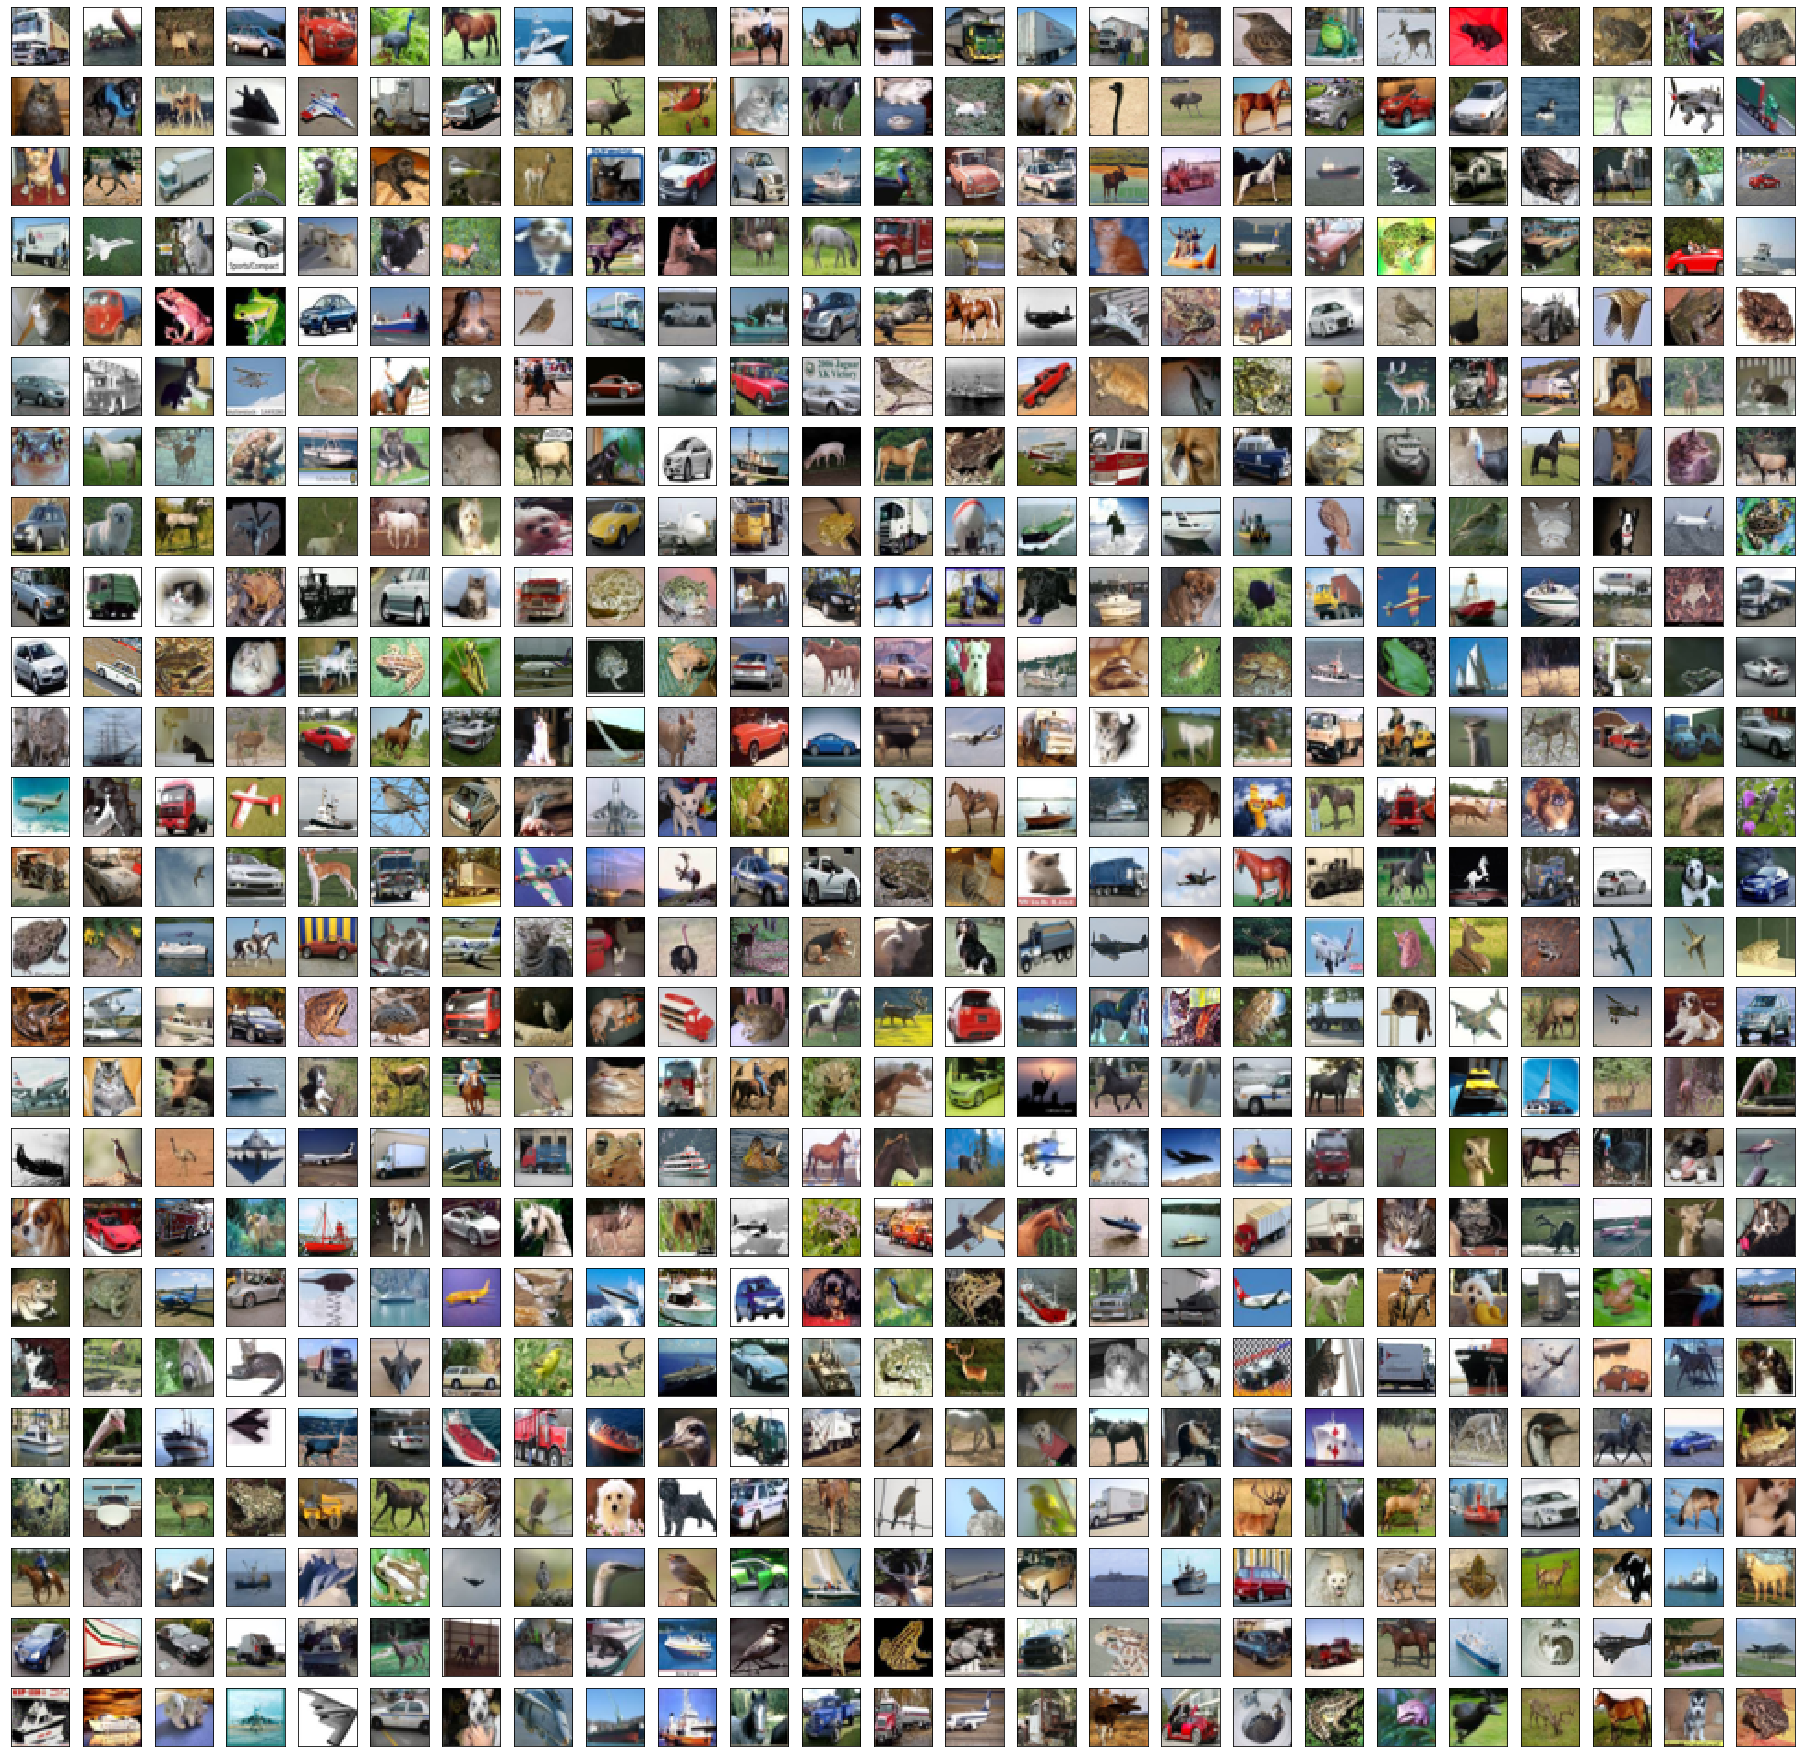

In [ ]:
# Visualization of 25 x 25 original images
fig = plt.figure(figsize=(32,32))
ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25,25,ind)
        show(x_images[ind])
        plt.xticks([])
        plt.yticks([])
        ind+=1

Original images

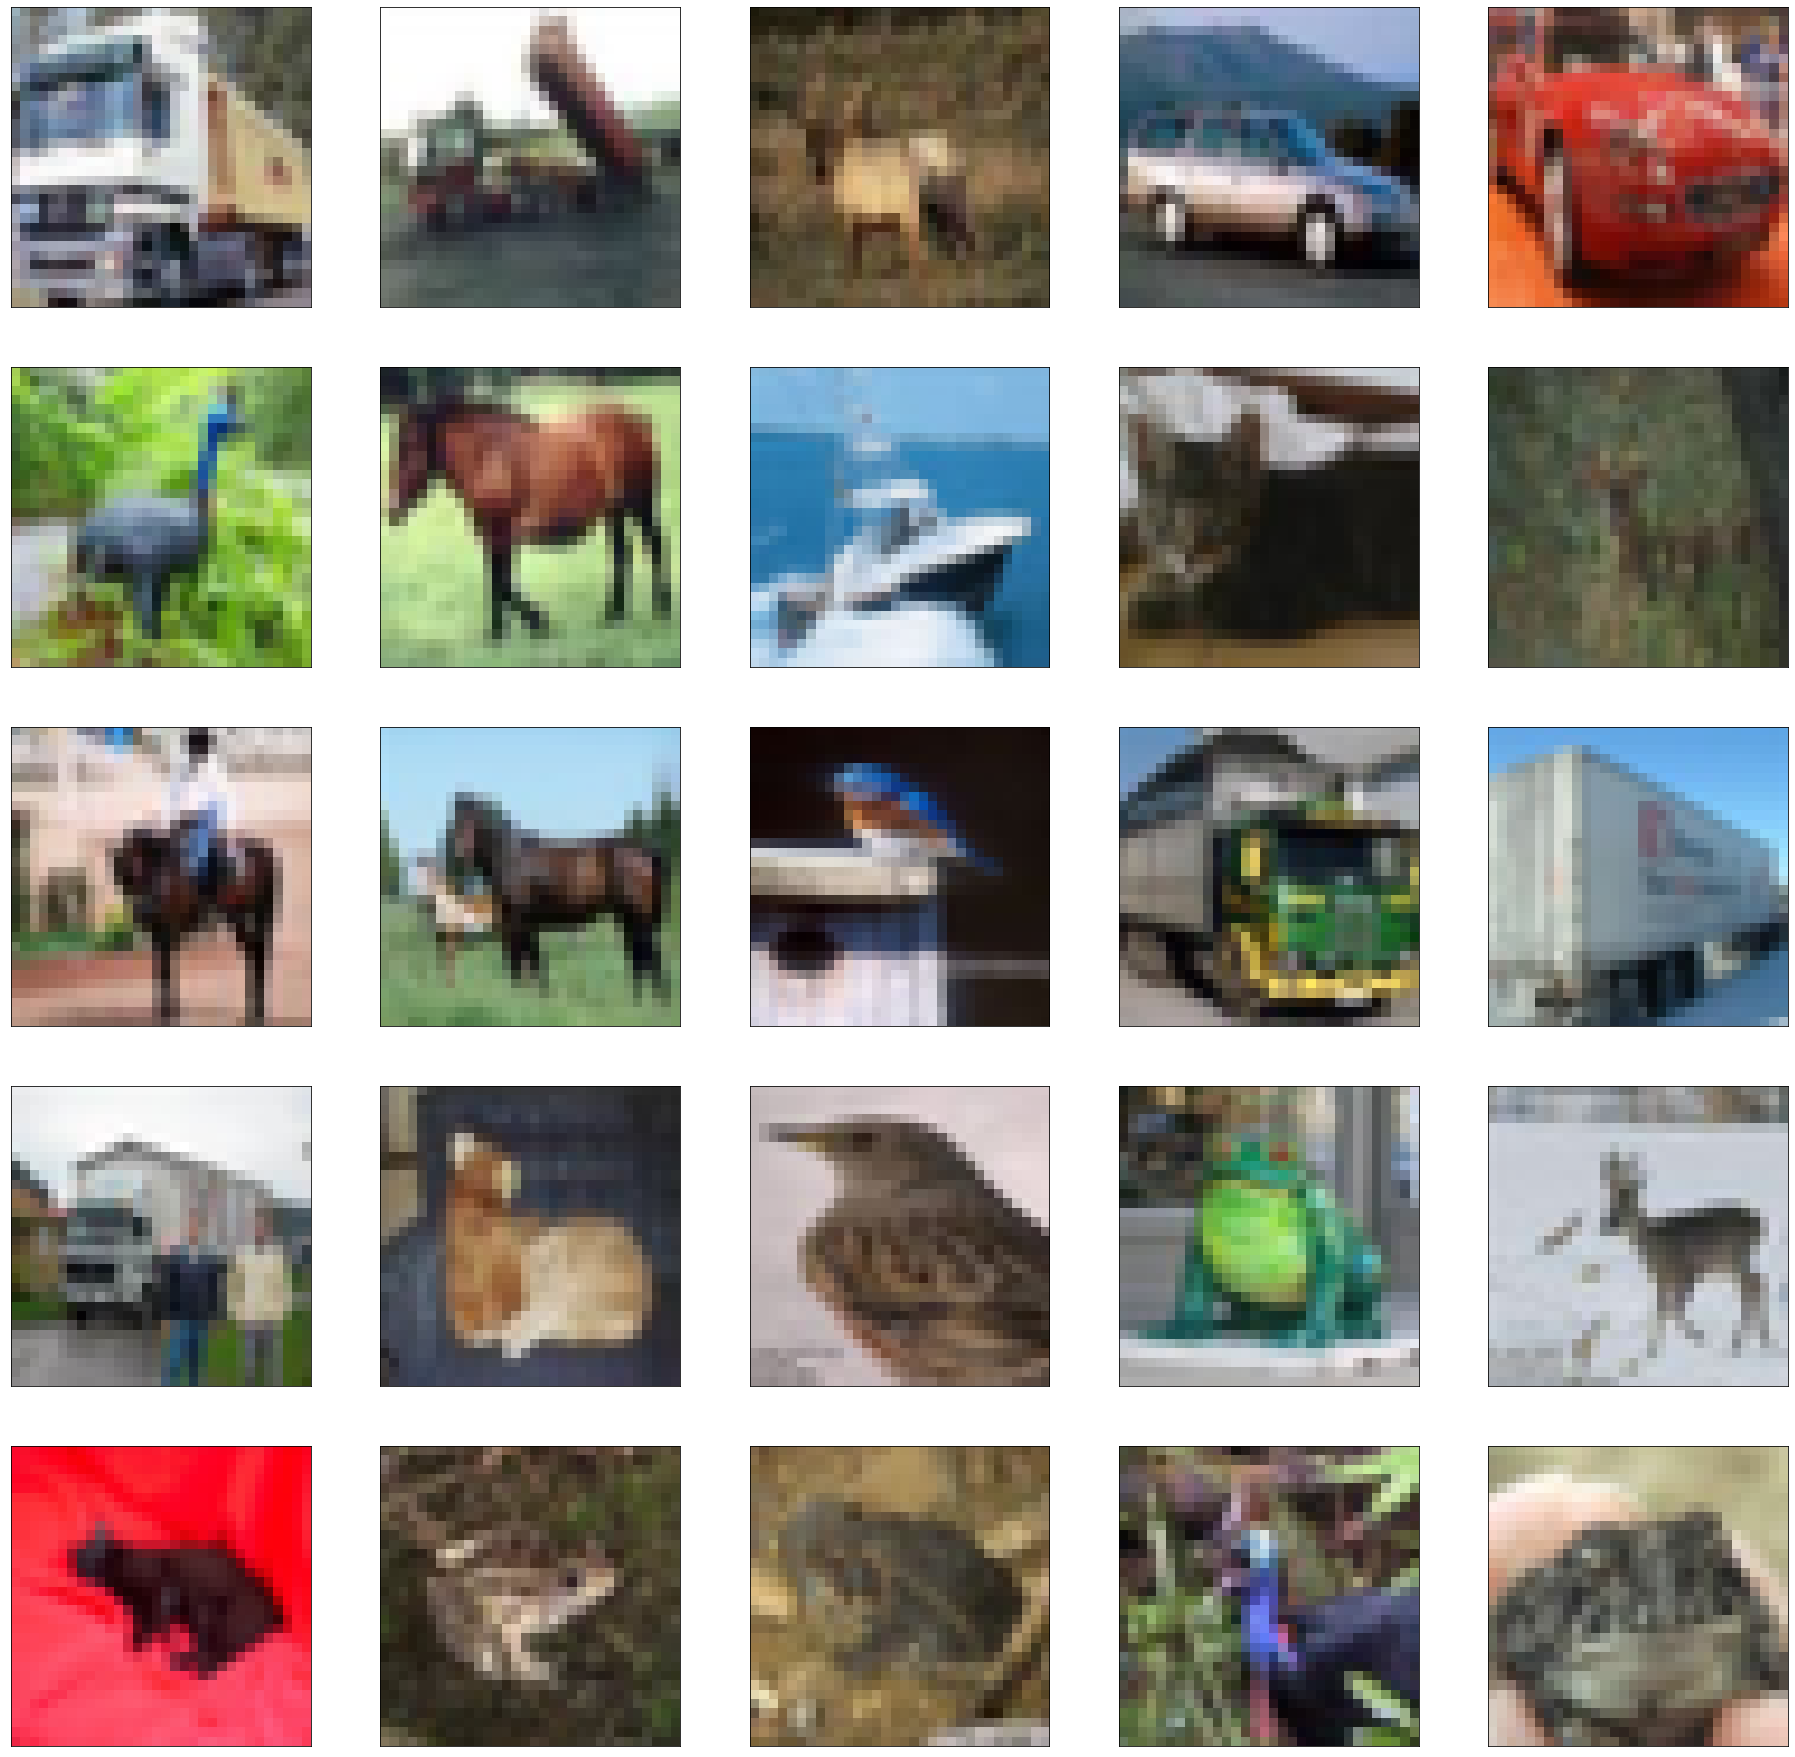

In [ ]:
# Visualization of 5 x 5 original images
fig = plt.figure(figsize=(32,32))
ind = 1
for i in range(1, 6, 1):
    for j in range(1, 6, 1):
        fig.add_subplot(5,5,ind)
        show(x_images[ind])
        plt.xticks([])
        plt.yticks([])
        ind+=1

Noisy images

In [ ]:
# Adding noise (mean = 0; std = 0.3)
noise = 0.3
x_train_noise = x_train + noise * np.random.normal(0, 0.3, size=x_train.shape)
x_test_noise = x_test + noise * np.random.normal(0, 0.3, size=x_test.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

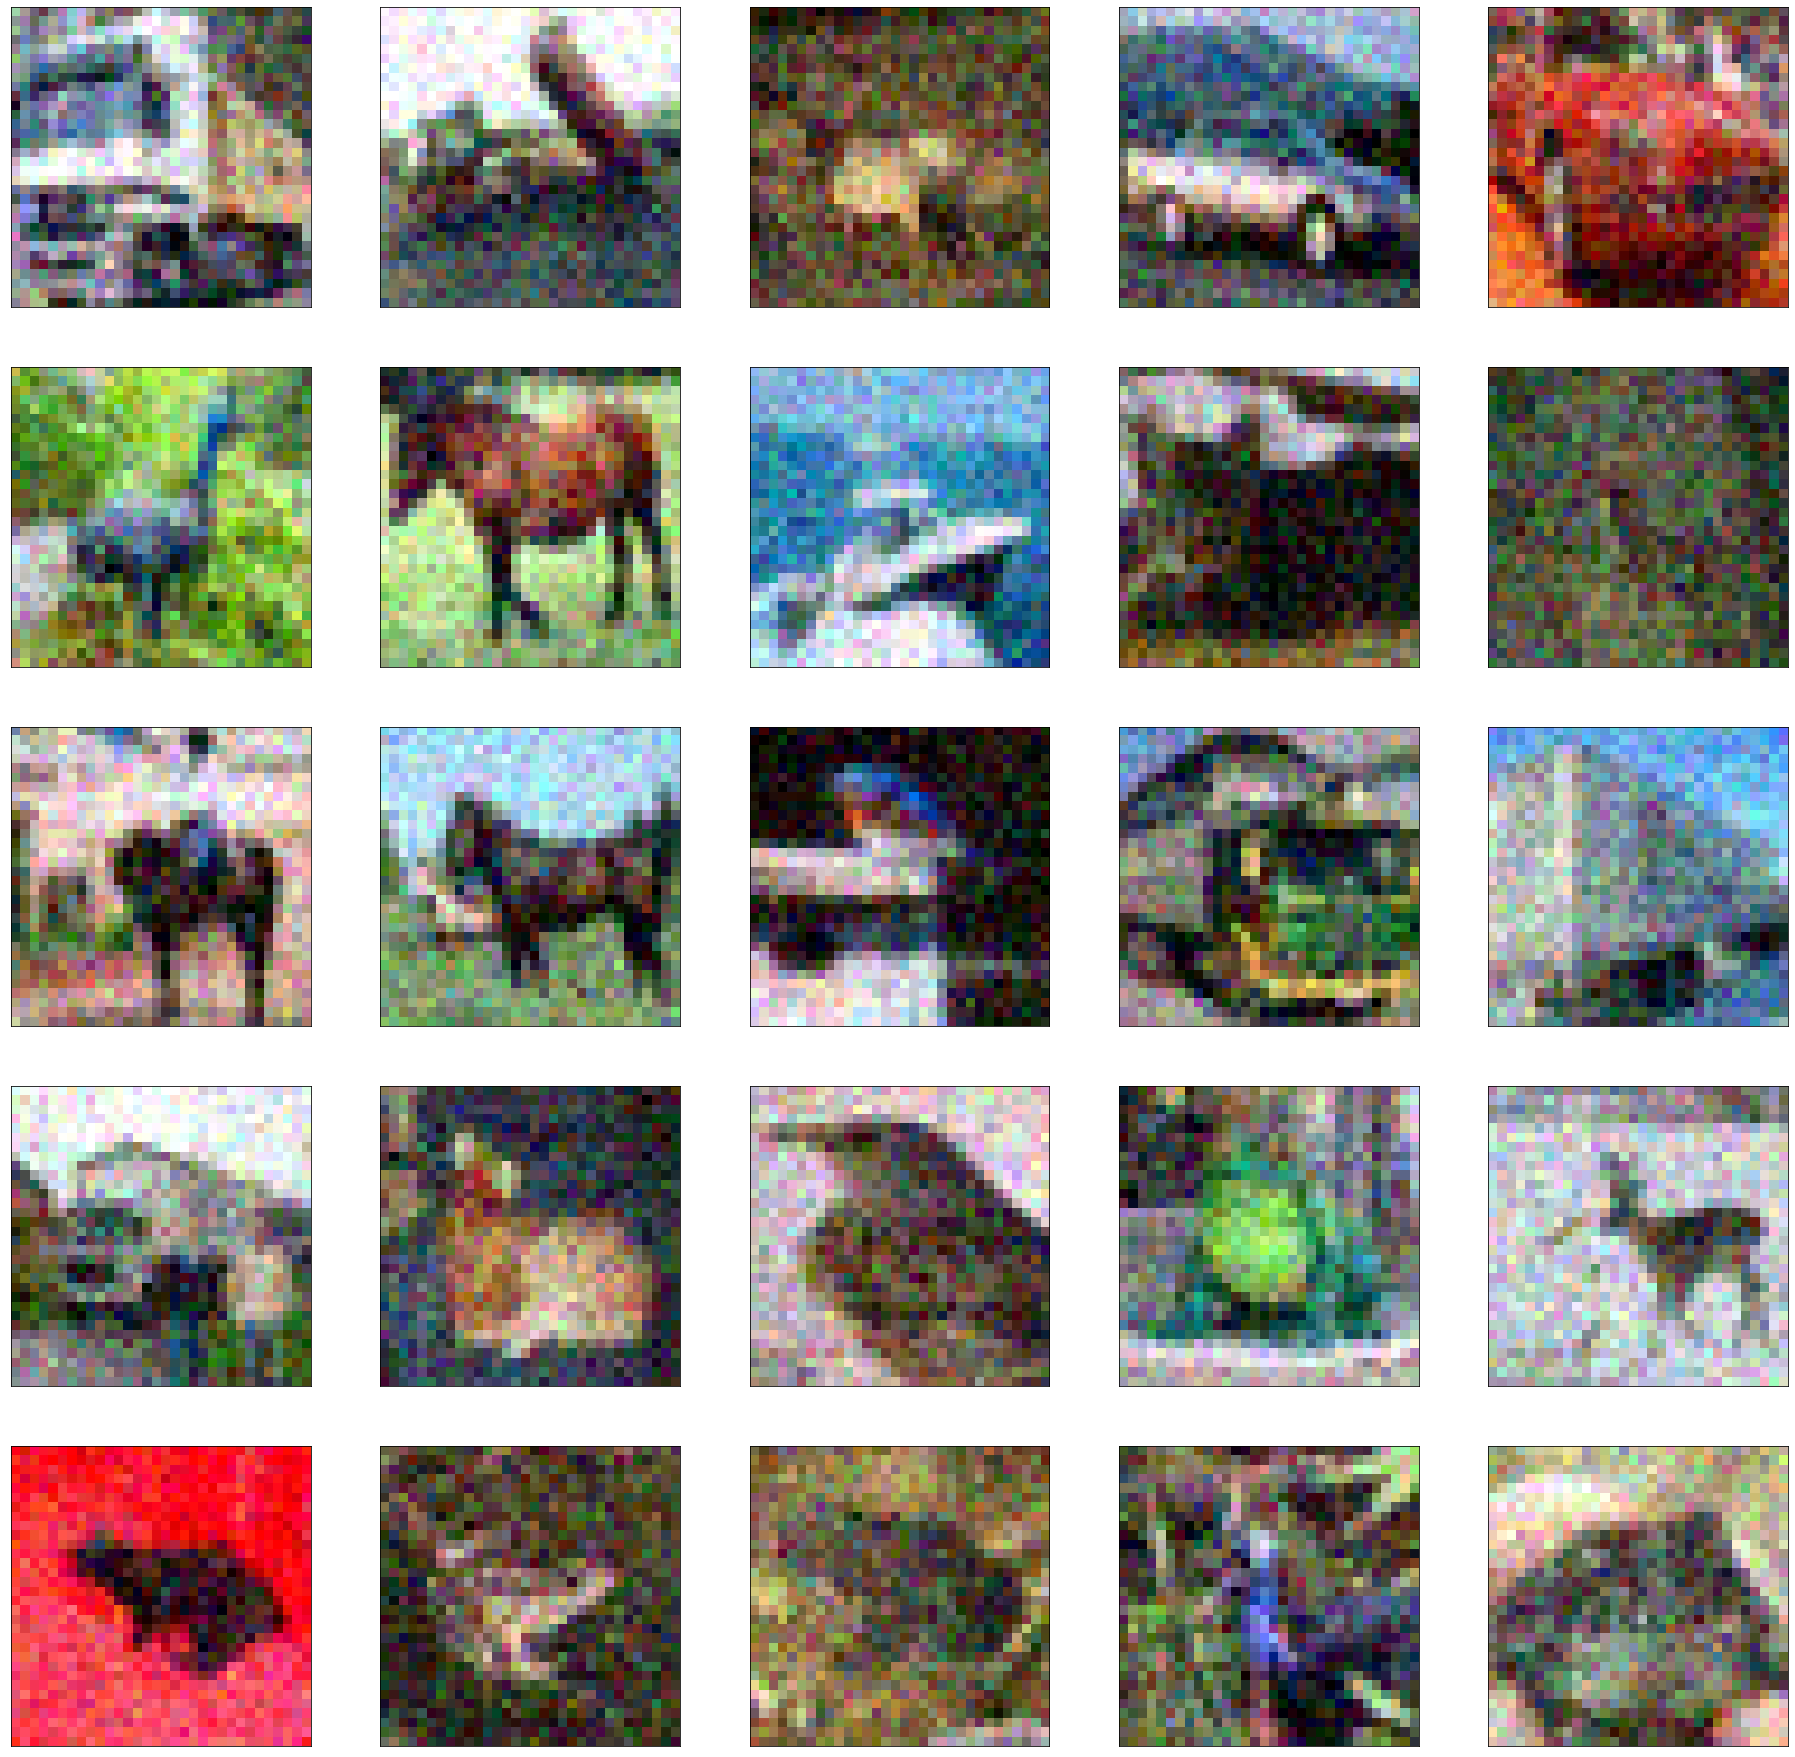

In [ ]:
# Visualization of 5 x 5 noisy images
fig = plt.figure(figsize=(32,32))
ind = 1
for i in range(1, 6, 1):
    for j in range(1, 6, 1):
        fig.add_subplot(5,5,ind)
        show(x_train_noise[ind])
        plt.xticks([])
        plt.yticks([])
        ind+=1

### 5.3 Proposal for the autoencoder architecture

Architecture and training history:

- Step 1: Training autoencoder with images without noise, just aiming image reconstruction.
- Step 2: Added BatchNorm layers.
- Step 3: Added Dropout layers.
- Step 4: Added skip connection (shortcut).

Reconstruction OK!

- Step 5: Added noise to input images and trained again.
- Step 6: Parameters adjusted.
- Step 7: Final training (architecture below).

In [ ]:
input_img = Input(shape=(32,32,3,))
#==========================================================
encoded = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(input_img)   # (50000,32,32,32)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.5)(encoded)
#-----------------------------
skip = Conv2D(64, (3, 3), activation=None, strides=2, padding='same')(encoded)          # (50000,16,16,32)
encoded = LeakyReLU()(skip)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.5)(encoded)
#-----------------------------
encoded = Conv2D(128, (3, 3), activation='relu', strides=2, padding='same')(encoded)     # (50000,8,8,64)
encoded = BatchNormalization()(encoded)
#-----------------------------
encoded = Flatten()(encoded)                                # (50000,1024)
#==========================================================
encoded = Dense(50, activation=None)(encoded)                # (50000,10) --> bottleneck
#==========================================================
decoded = Dense(2048, activation='tanh')(encoded)           # (50000,1152)
decoded = Reshape((4, 4, 128))(decoded)                                                         # (50000,3,3,128)
#-----------------------------
decoded = Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(decoded)    # (50000,7,7,64)
decoded = add([decoded, skip])
decoded = LeakyReLU()(decoded)
decoded = BatchNormalization()(decoded)
#-----------------------------
decoded = Conv2DTranspose(32, (3,3), strides=2, activation=None, padding='same')(decoded)    # (50000,8,8,64)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.5)(decoded)
#-----------------------------
decoded = Conv2DTranspose(3, (3,3), strides=2, activation='sigmoid', padding='same')(decoded)   # (50000,28,28,1)
#==========================================================
autoencoder = Model(input=input_img, output=decoded)

In [ ]:
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 16, 16, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

Training

In [ ]:
with device:
    autoencoder.compile(optimizer='adam', loss = "binary_crossentropy")
    history = autoencoder.fit(
        x_train_noise, 
        x_train, 
        batch_size = 128, 
        nb_epoch = 10, 
        verbose = 1,
    )

Epoch 1/10
50000/50000 [==============================] - 9s 184us/step - loss: 0.5784
Epoch 2/10
50000/50000 [==============================] - 7s 141us/step - loss: 0.5631
Epoch 3/10
50000/50000 [==============================] - 7s 138us/step - loss: 0.5622
Epoch 4/10
50000/50000 [==============================] - 7s 137us/step - loss: 0.5618
Epoch 5/10
50000/50000 [==============================] - 7s 139us/step - loss: 0.5615
Epoch 6/10
50000/50000 [==============================] - 7s 140us/step - loss: 0.5614
Epoch 7/10
50000/50000 [==============================] - 7s 138us/step - loss: 0.5613
Epoch 8/10
50000/50000 [==============================] - 7s 138us/step - loss: 0.5611
Epoch 9/10
50000/50000 [==============================] - 7s 139us/step - loss: 0.5611
Epoch 10/10
50000/50000 [==============================] - 7s 139us/step - loss: 0.5610


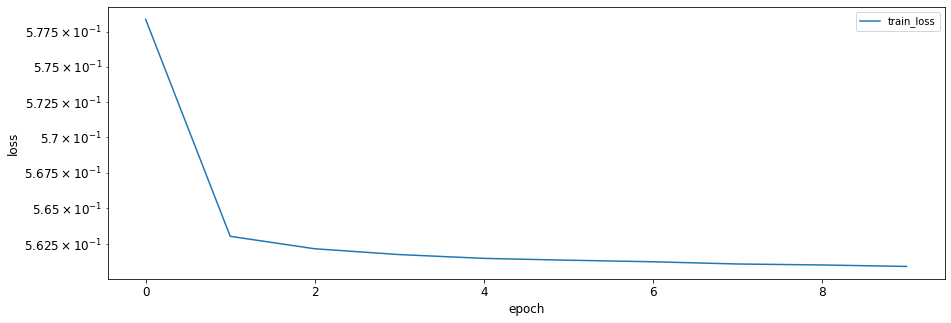

In [ ]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

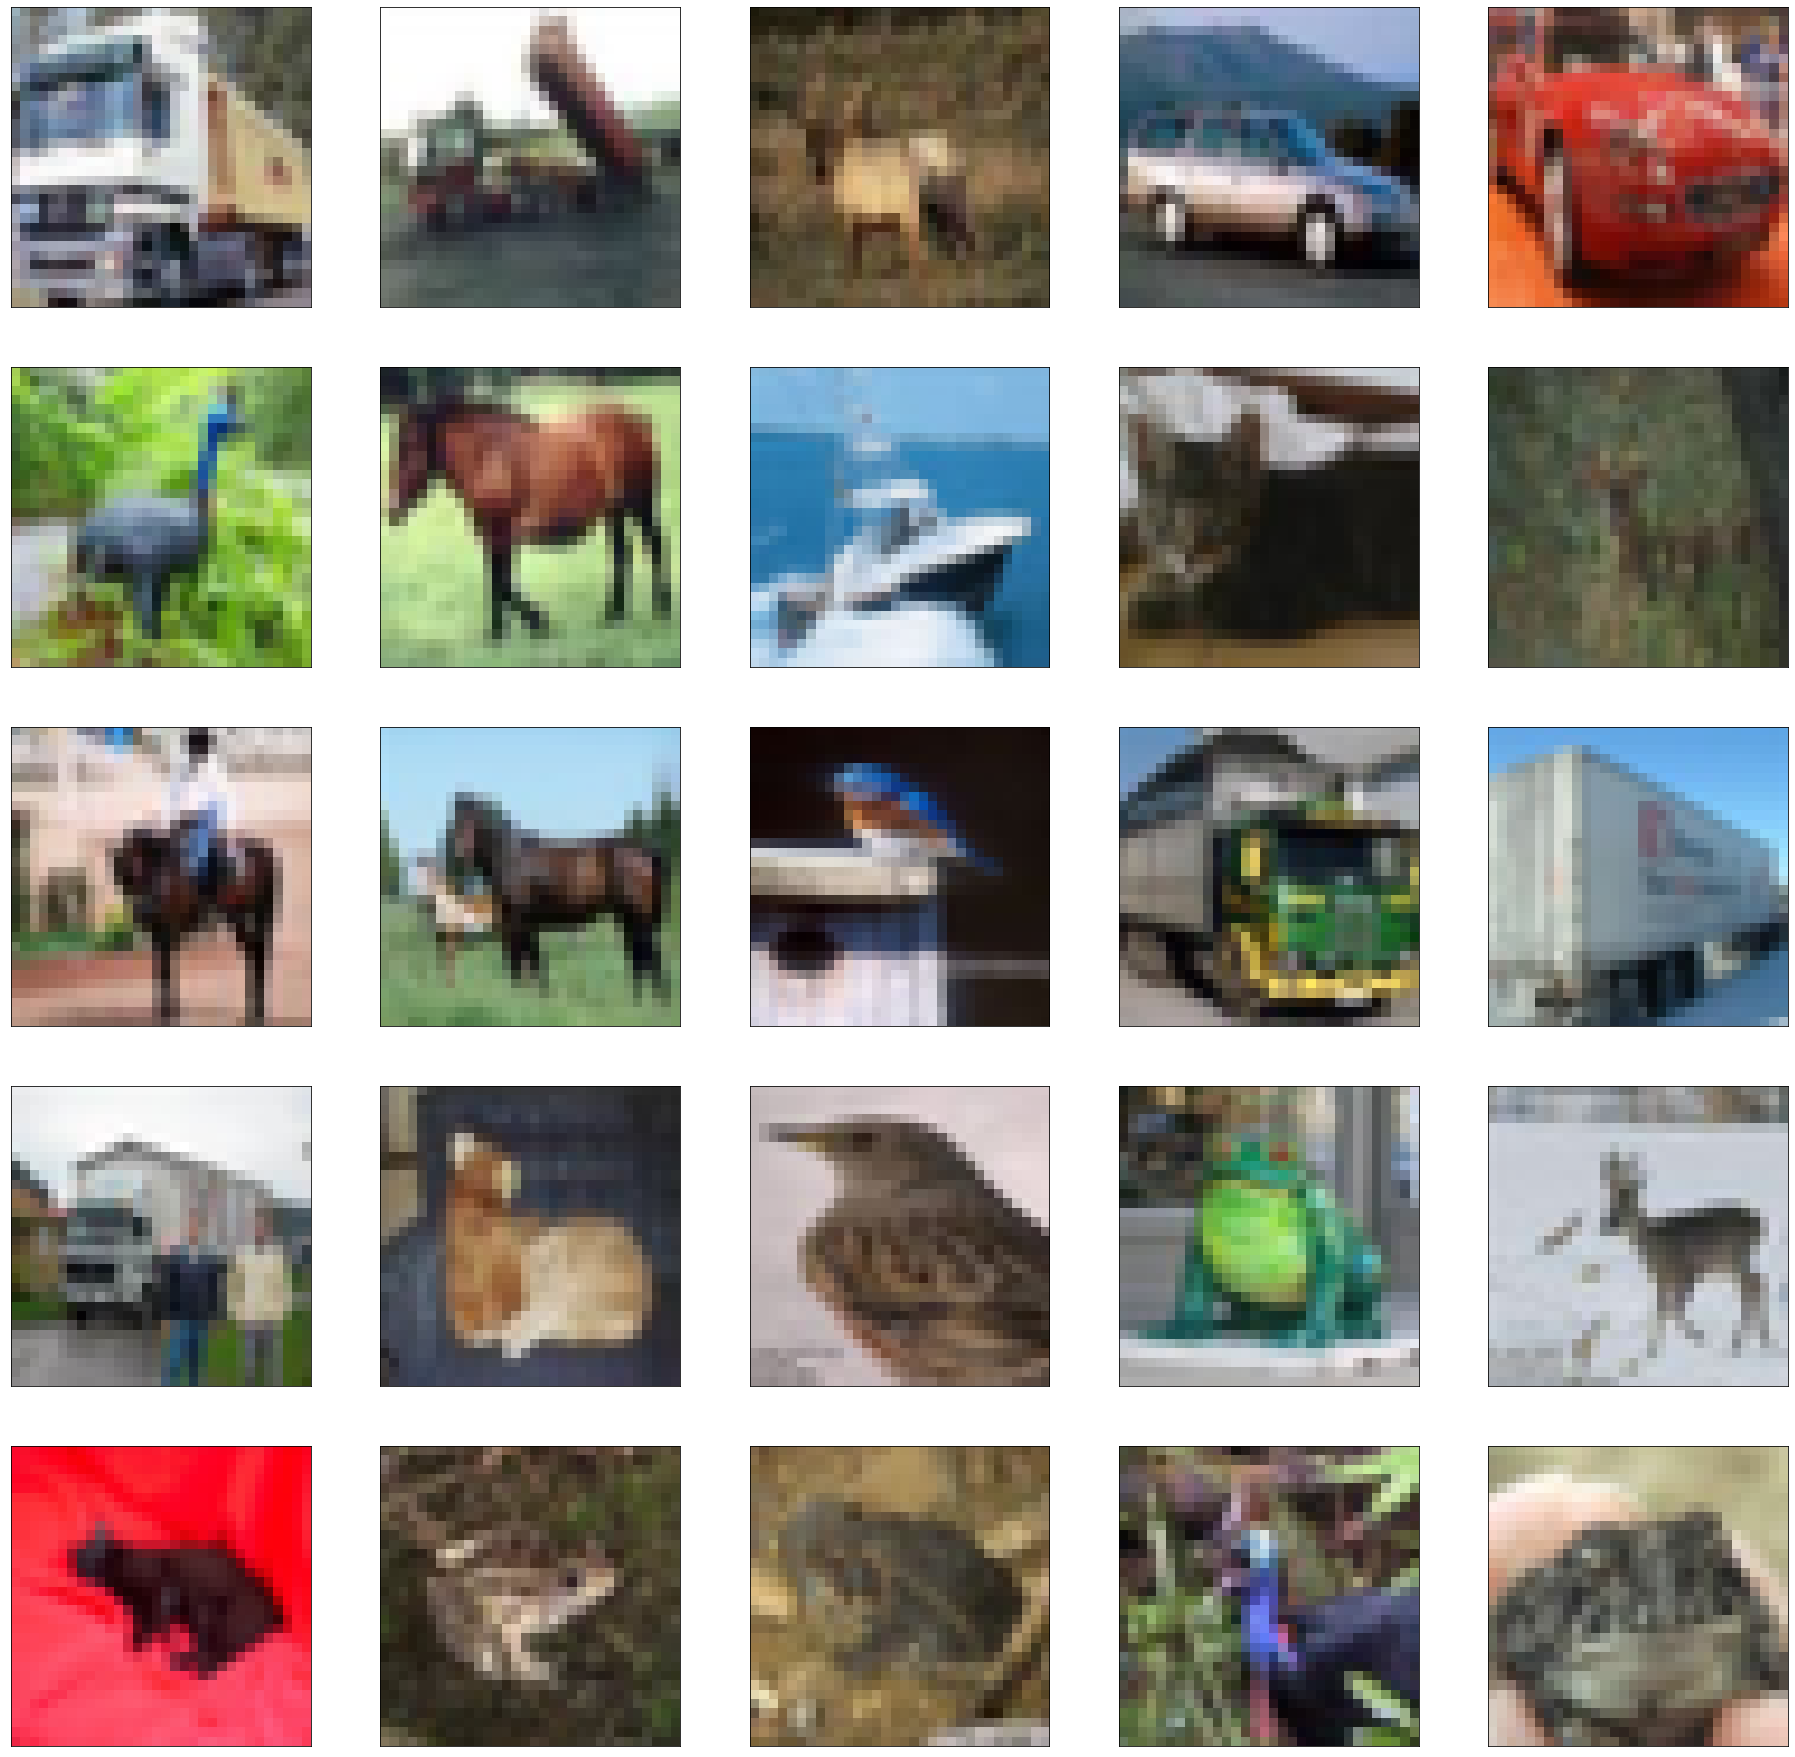

In [ ]:
# Visualization of 5 x 5 denoised images
fig = plt.figure(figsize=(32,32))
ind = 1
for i in range(1, 6, 1):
    for j in range(1, 6, 1):
        fig.add_subplot(5,5,ind)
        show(x_images[ind])
        plt.xticks([])
        plt.yticks([])
        ind+=1

### 5.4 Comparison between original, noisy and denoised images


- 1st column: original image  
- 2nd column: noisy image  
- 3rd column: denoised image

Images in training set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


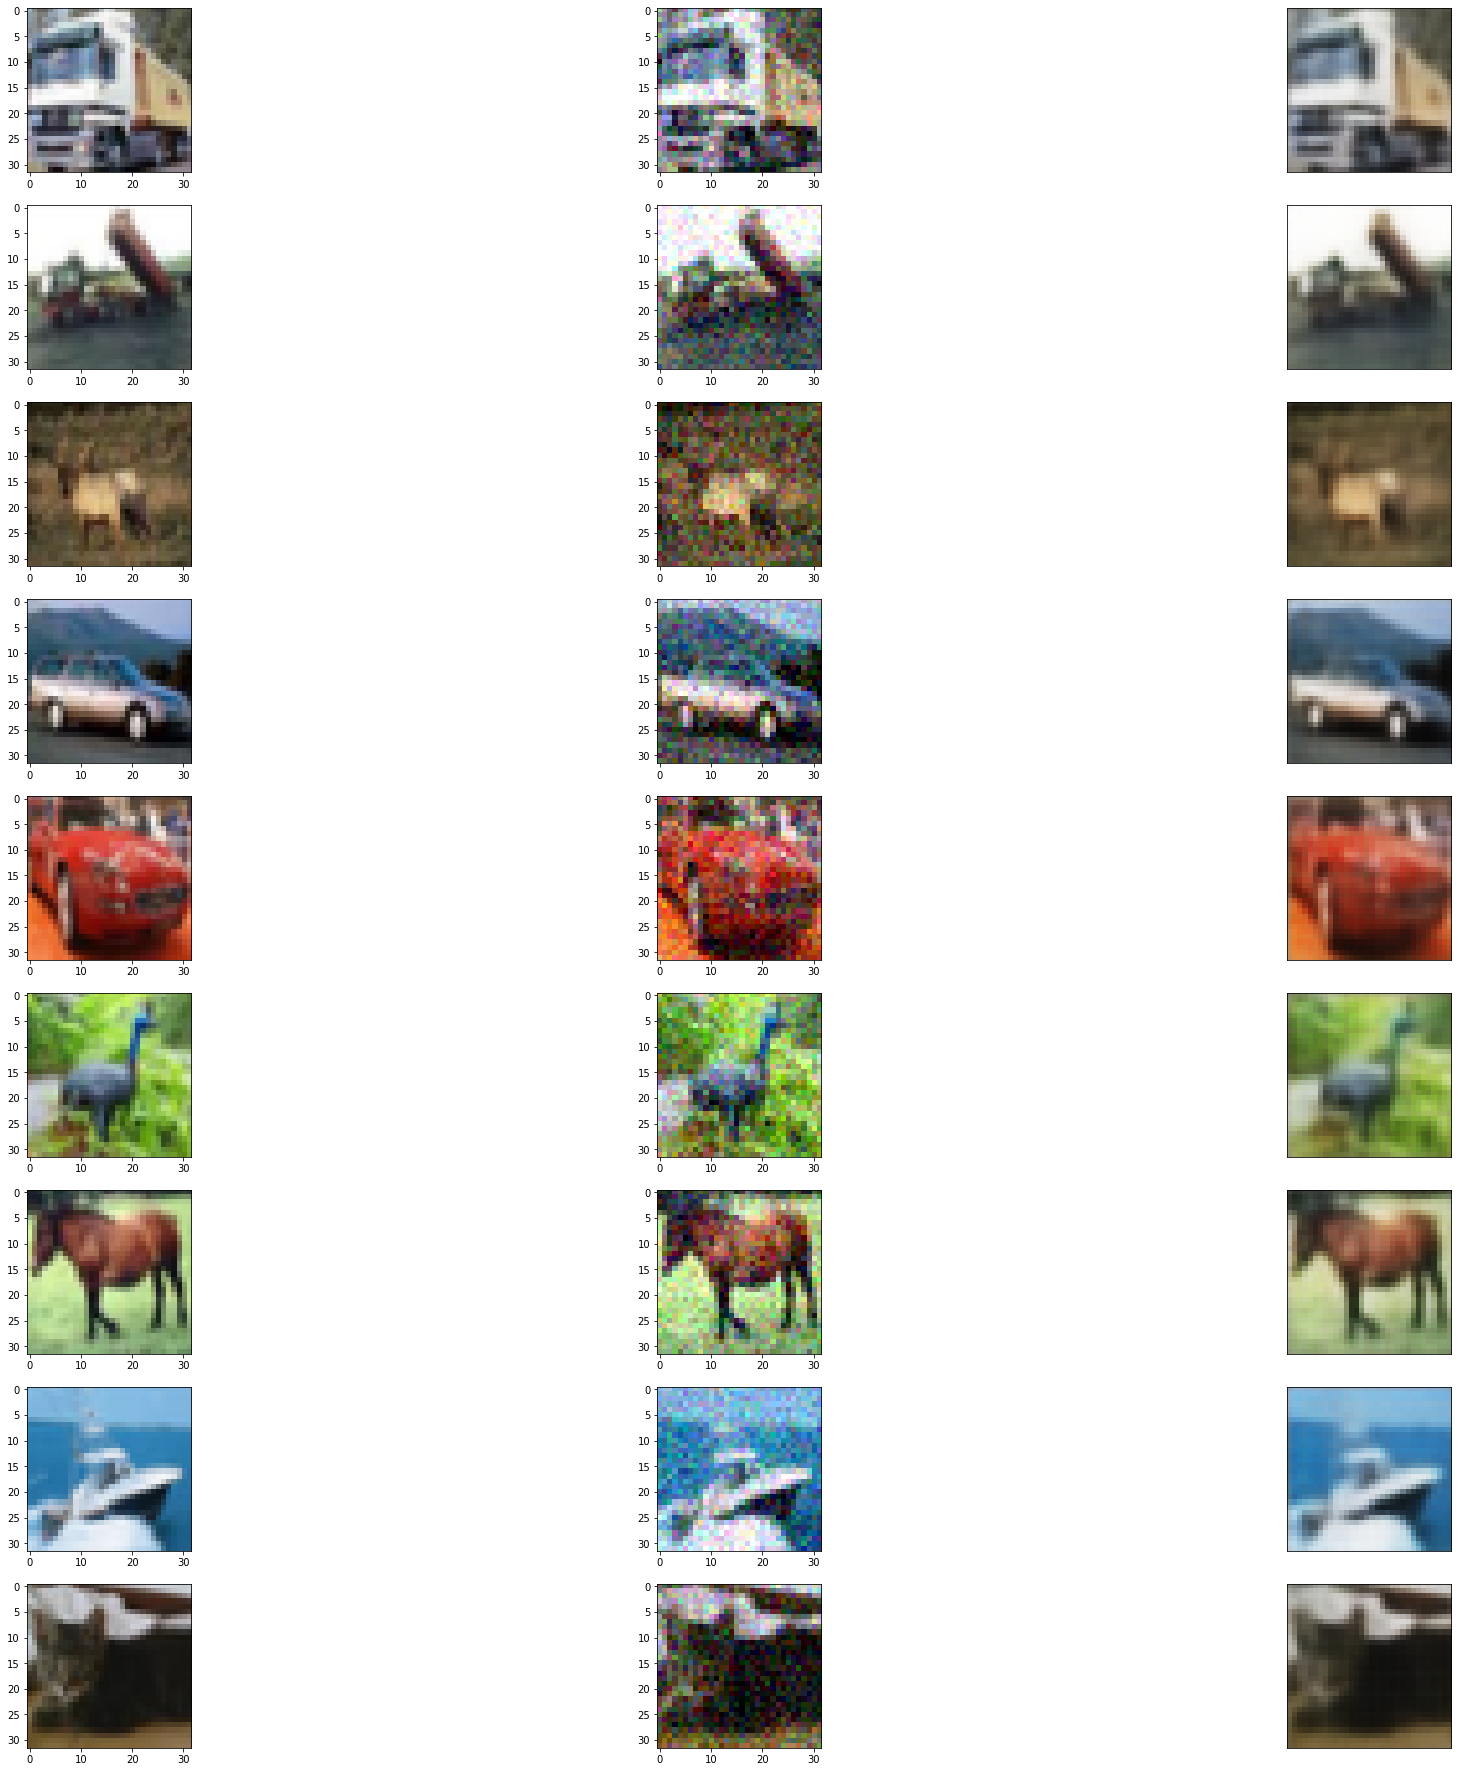

In [ ]:
# Visualization of 9 x 3 images
fig = plt.figure(figsize=(32,32))
ind = 1
for j in range(1, 10, 1):
    #-----------------------------
    # original images
    fig.add_subplot(9,3,ind)
    show(x_images[j])
    #-----------------------------
    # noisy images
    fig.add_subplot(9,3,ind+1)
    show(x_train_noise[j])
    #-----------------------------
    # denoised images
    fig.add_subplot(9,3,ind+2)
    show(np.squeeze(autoencoder.predict(np.expand_dims(x_images[j], 0))))
    #-----------------------------
    plt.xticks([])
    plt.yticks([])
    ind+=3

Images in test set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


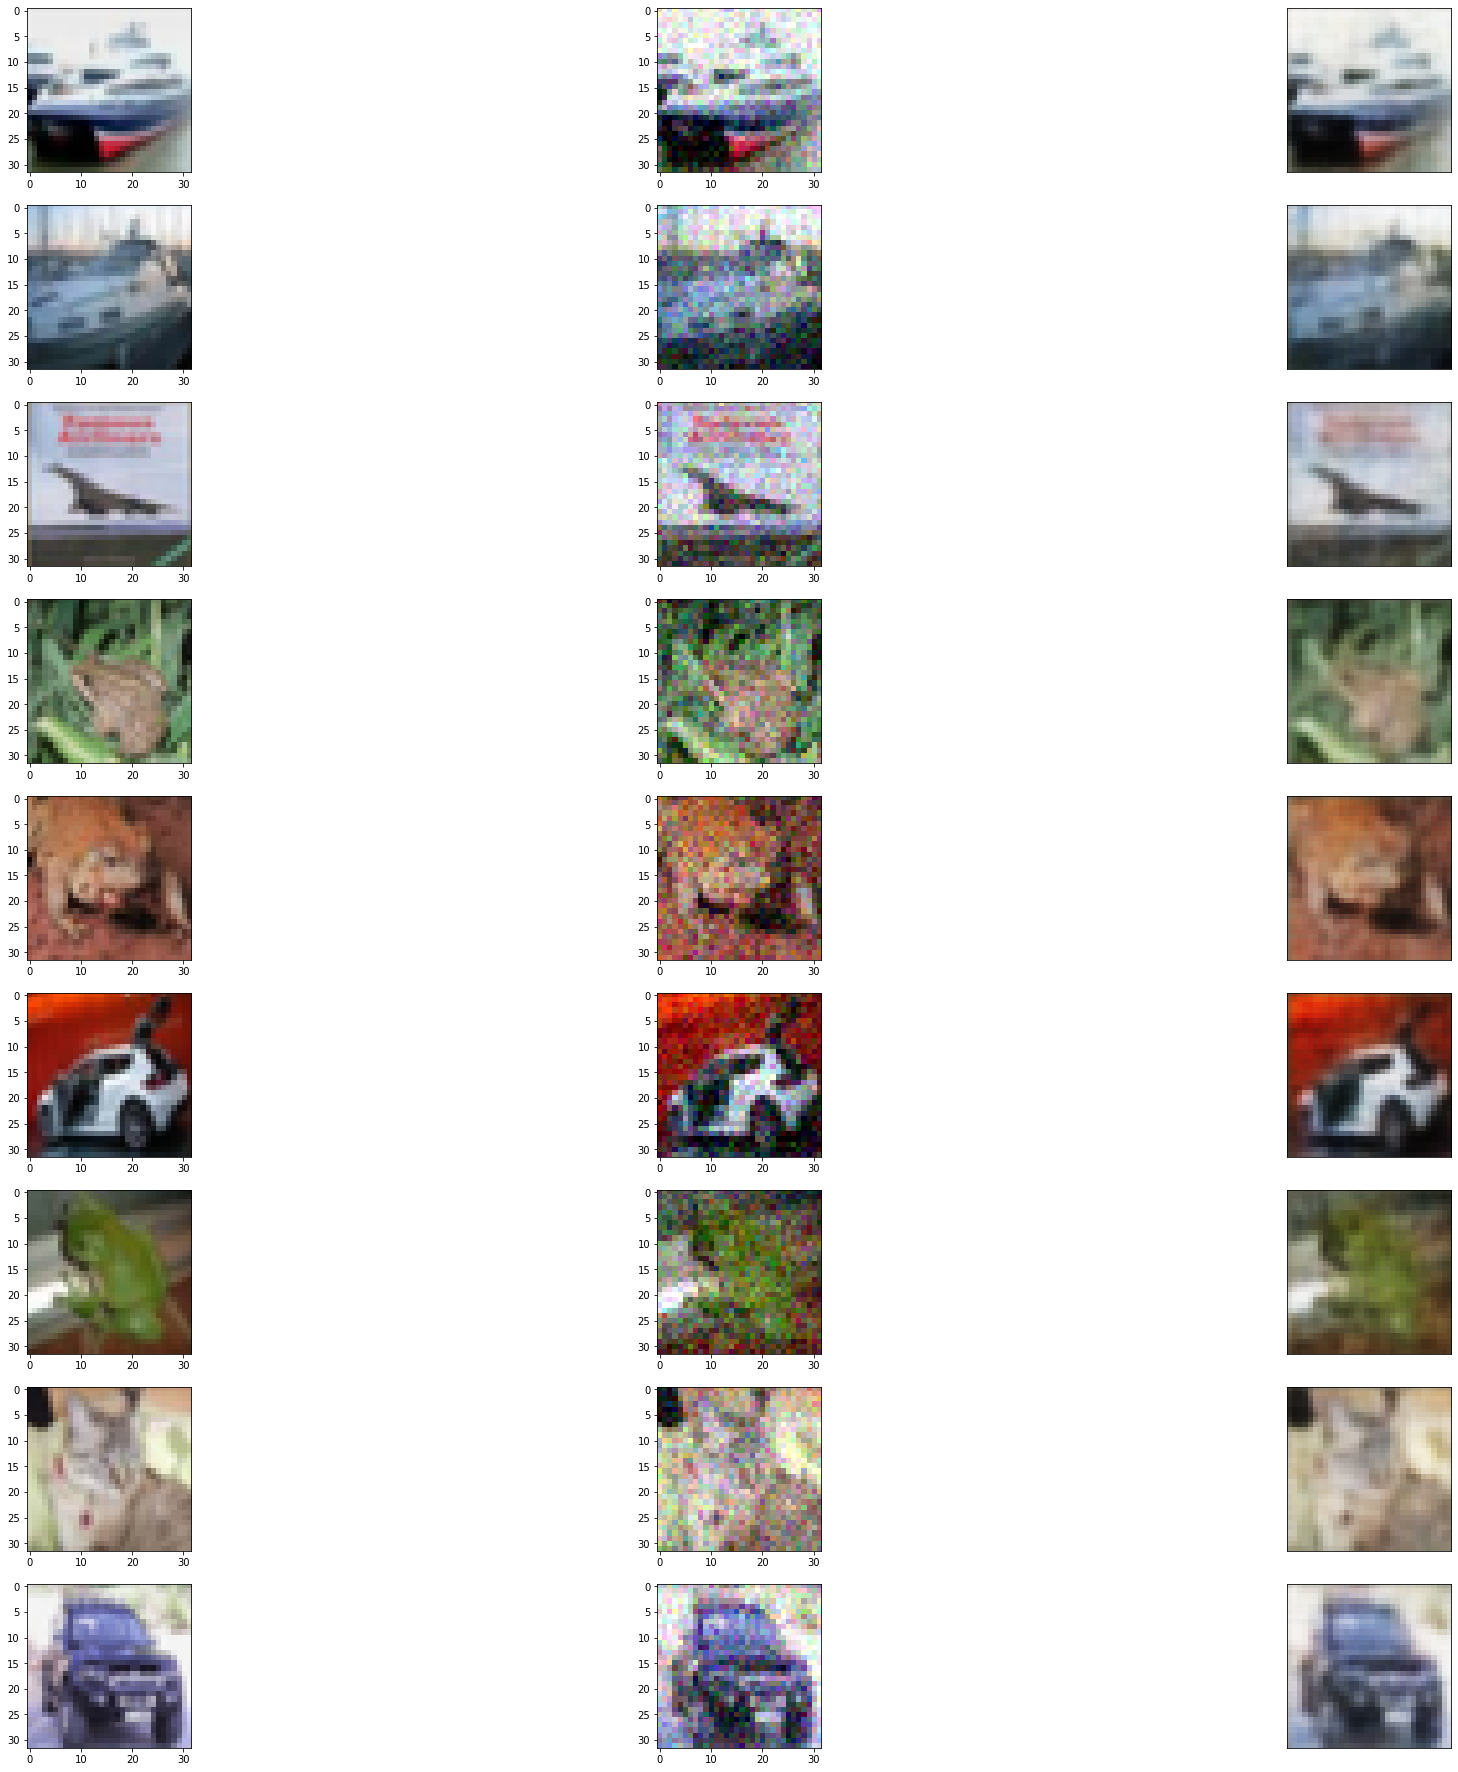

In [ ]:
# Visualization of 9 x 3 images
fig = plt.figure(figsize=(32,32))
ind = 1
for j in range(1, 10, 1):
    #-----------------------------
    # original images
    fig.add_subplot(9,3,ind)
    show(x_test[j])
    #-----------------------------
    # noisy images
    fig.add_subplot(9,3,ind+1)
    show(x_test_noise[j])
    #-----------------------------
    # reconstructed images
    fig.add_subplot(9,3,ind+2)
    show(np.squeeze(autoencoder.predict(np.expand_dims(x_test_noise[j], 0))))
    #-----------------------------
    plt.xticks([])
    plt.yticks([])
    ind+=3

Comments:  
As we can see, the DAE (Denoising Autoencoder) is able the remove noise from images. The denoised image is somewhat distorced from the original one (as expected), but it still has quality far better than the noisy images.

End of Notebook